# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## General parameters

In [5]:
n_iter_fs = 1
n_iter = 1
contamination_percentage = [0.8] 
trees = [25, 50, 100]

## Credit card

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [6]:
dataset_id = 'creditcard'
data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(284807, 29)

In [7]:
pd.pivot_table(data,
             values = 'V1',
               index = 'y', 
              aggfunc = 'count')

,V1
y,
0,284315
1,492


In [8]:
excluded_cols = []

### iForest

## Parameters

In [9]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)

var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'model_stab', 'shap_q2', 'shap_ad_q2']
df = df[var]
df

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_q2,shap_ad_q2
0,1,2,2,0.000000,0.000000,0.836016,0.083711,0.083711
1,1,4,4,0.000000,0.000000,0.820371,0.354720,0.704608
2,1,6,6,0.000000,0.000000,0.804685,0.482596,0.772252
3,1,9,9,0.000000,0.000000,0.812805,0.483637,0.774592
4,1,11,11,0.000000,0.000000,0.805148,0.530540,0.694773
...,...,...,...,...,...,...,...,...
61,100,17,17,0.069782,0.036408,0.983021,0.905889,0.924099
62,100,20,20,0.066958,0.034909,0.981450,0.890693,0.898485
63,100,24,24,0.066542,0.034692,0.983064,0.880061,0.915396
64,100,28,28,0.067336,0.035115,0.980799,0.865962,0.890392


## Optimization

In [19]:
df.sort_values("precision", ascending=False)

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_q2,shap_ad_q2,opt_value
56,100,17,17,0.069782,0.036408,0.983021,0.905889,0.924099,0.471149
36,50,17,17,0.069679,0.036352,0.969196,0.836439,0.894333,0.436395
46,75,17,17,0.068951,0.035974,0.978436,0.879344,0.910223,0.457659
10,5,2,2,0.067481,0.035604,0.879976,0.400148,0.400148,0.217876
28,25,24,24,0.067973,0.035442,0.950574,0.706492,0.846444,0.370967
38,50,24,24,0.067959,0.035435,0.972059,0.798868,0.876681,0.417151
35,50,14,14,0.067825,0.035371,0.968843,0.854523,0.882209,0.444947
39,50,28,28,0.067712,0.035310,0.963771,0.770258,0.823619,0.402784
26,25,17,17,0.067482,0.035204,0.961043,0.769769,0.866790,0.402486
59,100,28,28,0.067336,0.035115,0.980799,0.865962,0.890392,0.450538


In [22]:
sorted_df = opt_value(df, lambda_=0.95)

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df

,n_estimators,max_feats,n_feats,f1_median,precision,model_stab,shap_q2,shap_ad_q2,opt_value
56,100,17,17,0.069782,0.036408,0.983021,0.905889,0.924099,0.079882
55,100,14,14,0.066294,0.034557,0.983983,0.922525,0.937476,0.078956
46,75,17,17,0.068951,0.035974,0.978436,0.879344,0.910223,0.078143
45,75,14,14,0.066932,0.034904,0.977916,0.898951,0.881839,0.078106
57,100,20,20,0.066958,0.034909,0.981450,0.890693,0.898485,0.077698
58,100,24,24,0.066542,0.034692,0.983064,0.880061,0.915396,0.076961
59,100,28,28,0.067336,0.035115,0.980799,0.865962,0.890392,0.076657
36,50,17,17,0.069679,0.036352,0.969196,0.836439,0.894333,0.076356
35,50,14,14,0.067825,0.035371,0.968843,0.854523,0.882209,0.076329
53,100,9,9,0.058339,0.030437,0.990738,0.932788,0.906379,0.075554


## Visualization of the results

In [12]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'max_feats'])['n_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_max_feat = df.loc[idx].reset_index(drop=True)

In [13]:
df = df_n_trees.copy()

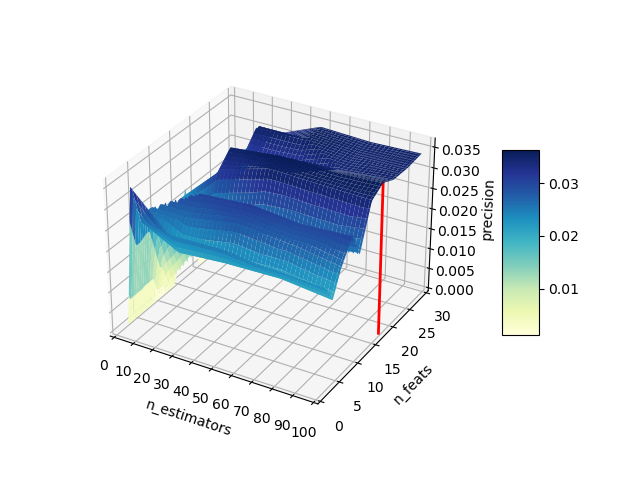

In [14]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'precision', cmap='YlGnBu', y_step=5, opt_x=opt_x, opt_y=opt_y, opt_color='red')


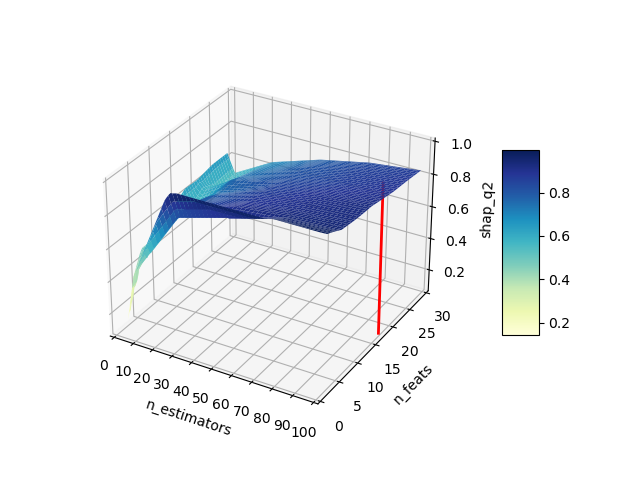

In [15]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'shap_q2', cmap='YlGnBu', y_step=5, opt_x=opt_x, opt_y=opt_y, opt_color='red')


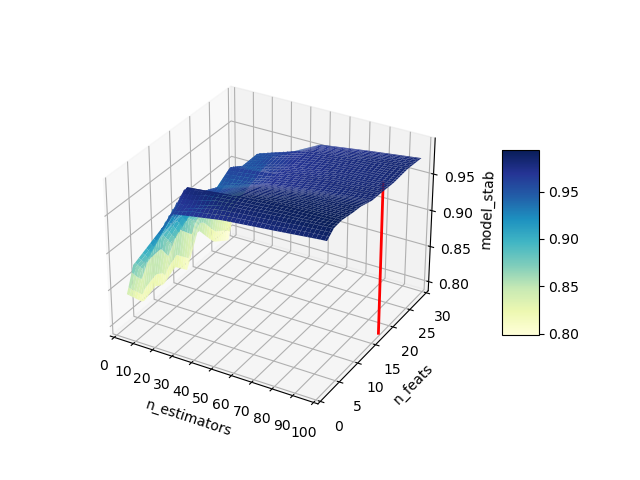

In [16]:
# Example usage (assuming 'df' is your DataFrame)
plot_3d_surface(df, 'n_estimators', 'n_feats', 'model_stab', cmap='YlGnBu', y_step=5, opt_x=opt_x, opt_y=opt_y, opt_color='red')
